In [1]:
import warnings # Omitir mensajes de advertencia
warnings.filterwarnings("ignore")

In [2]:
# Trabajamos en colab:
from google.colab import drive
drive.mount('/content/drive/')

import os

path = '/content/drive/MyDrive/Colab Notebooks/' # Directorio de trabajo

os.chdir(path)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [3]:
# %%capture
# !pip install pygrib
# !pip install cartopy

In [4]:
import pygrib as pg
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
import matplotlib.colors as colors
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Abrimos el archivo grib
# --------------------------------------------------------------
grbs = pg.open(path + 'Clase_8/todo.grb2')
grbs

In [6]:
# --------------------------------------------------------------
u = grbs.message(420) # u a 700 mb, en el t 0
v = grbs.message(421) # v a 700 mb, en el t 0
t = grbs.message(414) # temp a 700 mb, en el t 0
t

414:Temperature:K (instant):regular_ll:isobaricInhPa:level 70000 Pa:fcst time 0 hrs:from 202402061800

In [7]:
data_t = t.values
data_u = u.values
data_v = v.values
data_t

array([[253.81583984, 253.81583984, 253.81583984, ..., 253.81583984,
        253.81583984, 253.81583984],
       [254.37583984, 254.38583984, 254.39583984, ..., 254.35583984,
        254.36583984, 254.37583984],
       [254.76583984, 254.77583984, 254.78583984, ..., 254.74583984,
        254.75583984, 254.76583984],
       ...,
       [239.80583984, 239.81583984, 239.83583984, ..., 239.75583984,
        239.76583984, 239.78583984],
       [241.05583984, 241.04583984, 241.04583984, ..., 241.05583984,
        241.05583984, 241.05583984],
       [241.64583984, 241.64583984, 241.64583984, ..., 241.64583984,
        241.64583984, 241.64583984]])

# CREANDO DATASET

In [8]:
lats, lons = t.latlons()
lats, lons

(array([[ 90. ,  90. ,  90. , ...,  90. ,  90. ,  90. ],
        [ 89.5,  89.5,  89.5, ...,  89.5,  89.5,  89.5],
        [ 89. ,  89. ,  89. , ...,  89. ,  89. ,  89. ],
        ...,
        [-89. , -89. , -89. , ..., -89. , -89. , -89. ],
        [-89.5, -89.5, -89.5, ..., -89.5, -89.5, -89.5],
        [-90. , -90. , -90. , ..., -90. , -90. , -90. ]]),
 array([[  0. ,   0.5,   1. , ..., 358.5, 359. , 359.5],
        [  0. ,   0.5,   1. , ..., 358.5, 359. , 359.5],
        [  0. ,   0.5,   1. , ..., 358.5, 359. , 359.5],
        ...,
        [  0. ,   0.5,   1. , ..., 358.5, 359. , 359.5],
        [  0. ,   0.5,   1. , ..., 358.5, 359. , 359.5],
        [  0. ,   0.5,   1. , ..., 358.5, 359. , 359.5]]))

In [9]:
# Asegúrate de que lats y lons sean de una dimensión
lats_1d = lats[:, 0]
lons_1d = lons[0, :]

# Crear el Dataset (porque tiene más de 1 variable)
dset = xr.Dataset({"t": (["lat", "lon"], data_t),
                        "u": (["lat", "lon"], data_u),
                        "v": (["lat", "lon"], data_v)},
                       coords={"lat": lats_1d,"lon": lons_1d})

dset

<xarray.Dataset>
Dimensions:  (lat: 361, lon: 720)
Coordinates:
  * lat      (lat) float64 90.0 89.5 89.0 88.5 88.0 ... -88.5 -89.0 -89.5 -90.0
  * lon      (lon) float64 0.0 0.5 1.0 1.5 2.0 ... 357.5 358.0 358.5 359.0 359.5
Data variables:
    t        (lat, lon) float64 253.8 253.8 253.8 253.8 ... 241.6 241.6 241.6
    u        (lat, lon) float64 6.406 6.546 6.696 6.846 ... 2.766 2.776 2.796
    v        (lat, lon) float64 17.01 16.96 16.9 16.84 ... -1.79 -1.77 -1.74

# GRAFICAMOS CON XARRAY Y CARTOPY

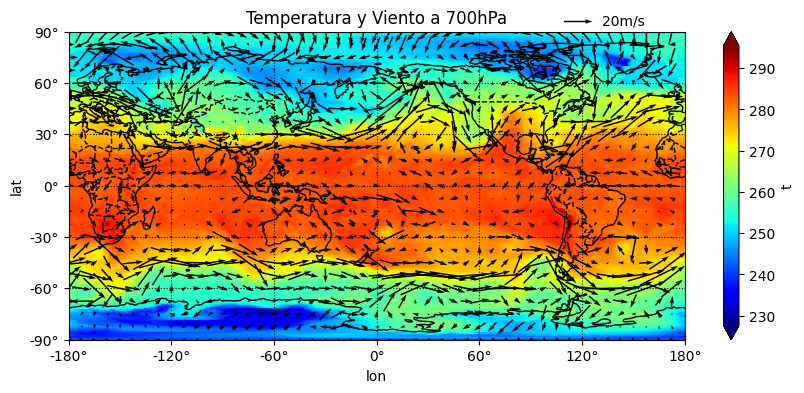

In [18]:
plt.figure(figsize=(10,4))
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
dset.t.plot(ax=ax, transform=ccrs.PlateCarree(), cmap='jet', extend='both')#,
            # vmin=230, vmax=290, levels=12, extend='both')
# ------------------------------------
muestreo = 15
viento = dset.thin({'lon':muestreo,'lat':muestreo})
# ------------------------------------
q = viento.plot.quiver('lon','lat','u','v', scale=70, scale_units='inches', transform=ccrs.PlateCarree(),add_guide=False,ax=ax)
ax.quiverkey(q, 0.85, 1.035, 20, '20m/s', labelpos='E',coordinates='axes', color='black')
# ------------------------------------
ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black', color='gainsboro')
ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=1, ls='--')
ax.coastlines(resolution='110m', color='black', linewidth=1)
# ------------------------------------
ax.set_xticks(range(-180, 181, 60))  # Etiquetas de longitud cada 60°
ax.set_yticks(range(-90, 91, 30))   # Etiquetas de latitud cada 30°
# ------------------------------------
ax.set_xticklabels([f'{x}°' for x in range(-180, 181, 60)])
ax.set_yticklabels([f'{y}°' for y in range(-90, 91, 30)])
plt.grid(ls=':', color='black')
plt.title('Temperatura y Viento a 700hPa')
plt.show()




---


# Los datos utilizados se encuentran en el siguiente link:
https://drive.google.com/drive/folders/1zo4Uq3XS9KKn_I2Ei1J_FiYu4QryQnNt

---

